In [11]:
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
color = sns.color_palette()

In [12]:
train_df = pd.read_csv('train.csv')
train_df
test_df = pd.read_csv('test.csv')
test_df

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,30474,2015-07-01,39.00,20.70,2,9,1,1998.0,1,8.9,...,8,0,0,0,1,10,1,0,14,1
1,30475,2015-07-01,79.20,NaN,8,17,1,0.0,3,1.0,...,4,1,1,0,2,11,0,1,12,1
2,30476,2015-07-01,40.50,25.10,3,5,2,1960.0,2,4.8,...,42,11,4,0,10,21,0,10,71,11
3,30477,2015-07-01,62.80,36.00,17,17,1,2016.0,2,62.8,...,1,1,2,0,0,10,0,0,2,0
4,30478,2015-07-01,40.00,40.00,17,17,1,0.0,1,1.0,...,5,1,1,0,2,12,0,1,11,1
5,30479,2015-07-01,48.43,NaN,21,1,1,2015.0,1,1.0,...,143,99,57,12,23,42,1,13,123,7
6,30480,2015-07-01,38.80,NaN,15,17,1,NaN,1,1.0,...,12,7,2,0,5,14,0,3,17,2
7,30481,2015-07-01,43.10,NaN,5,0,1,NaN,1,0.0,...,5,2,2,0,3,12,0,0,6,3
8,30482,2015-07-01,45.40,28.50,9,12,5,1972.0,2,6.0,...,3,1,0,0,1,7,0,0,7,0
9,30483,2015-07-01,43.30,43.30,7,22,1,0.0,1,1.0,...,5,2,1,0,2,9,0,0,7,0


In [21]:
bad_index = train_df[train_df.life_sq > train_df.full_sq].index
train_df.loc[bad_index, "life_sq"] = np.NaN
bad_index = train_df[train_df.life_sq < 5].index
train_df.loc[bad_index, "life_sq"] = np.NaN
bad_index = train_df[train_df.full_sq < 5].index
train_df.loc[bad_index, "full_sq"] = np.NaN
bad_index = train_df[(train_df.full_sq > 210) & (train_df.life_sq / train_df.full_sq < 0.3)].index
train_df.loc[bad_index, "full_sq"] = np.NaN
bad_index = train_df[train_df.full_sq > 300].index
train_df.loc[bad_index, "full_sq"] = np.NaN

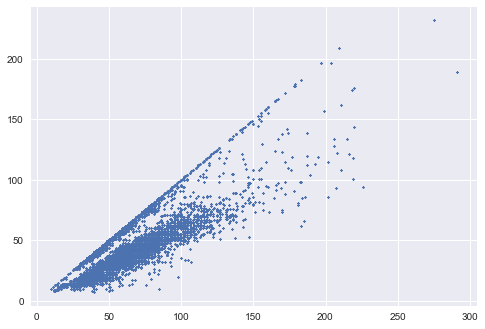

In [22]:
plt.scatter(train_df['full_sq'][:],train_df['life_sq'][:],s=2,marker='x')
plt.show()

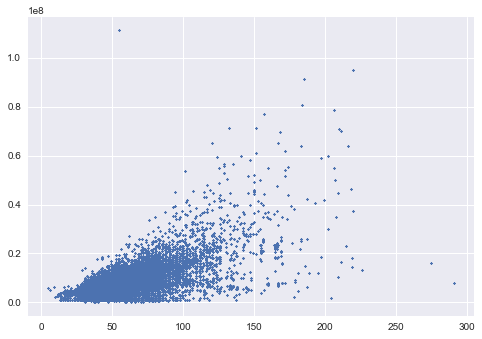

In [23]:
plt.scatter(train_df['full_sq'][:],train_df['price_doc'][:],s=2,marker='x')
plt.show()

In [17]:
train_df.describe().astype(np.int64).T

,count,mean,std,min,25%,50%,75%,max
id,30471,15237,8796,1,7620,15238,22855,30473
full_sq,30471,54,38,0,38,49,63,5326
life_sq,24088,34,52,0,20,30,43,7478
floor,30304,7,5,0,3,6,11,77
max_floor,20899,12,6,0,9,12,17,117
material,20899,1,1,1,1,1,2,6
build_year,16866,3068,154387,0,1967,1979,2005,20052009
num_room,20899,1,0,0,1,2,2,19
kitch_sq,20899,6,28,0,1,6,9,2014
state,16912,2,0,1,1,2,3,33


In [33]:
train_df['life_sq'].shape[0] - train_df['life_sq'].dropna(axis = 0).shape[0]

6383L

In [7]:
test_df.describe().astype(np.int64).T

,count,mean,std,min,25%,50%,75%,max
id,7662,34304,2211,30474,32389,34304,36219,38135
full_sq,7662,53,20,0,39,50,63,403
life_sq,6486,32,22,0,19,30,41,869
floor,7662,7,5,1,4,7,11,41
max_floor,7662,12,6,0,9,14,17,48
material,7662,1,1,1,1,1,2,6
build_year,6613,1820,552,0,1966,1982,2011,2019
num_room,7662,1,0,1,1,2,2,19
kitch_sq,7662,6,25,0,1,7,9,1968
state,6968,1,0,1,1,2,3,4


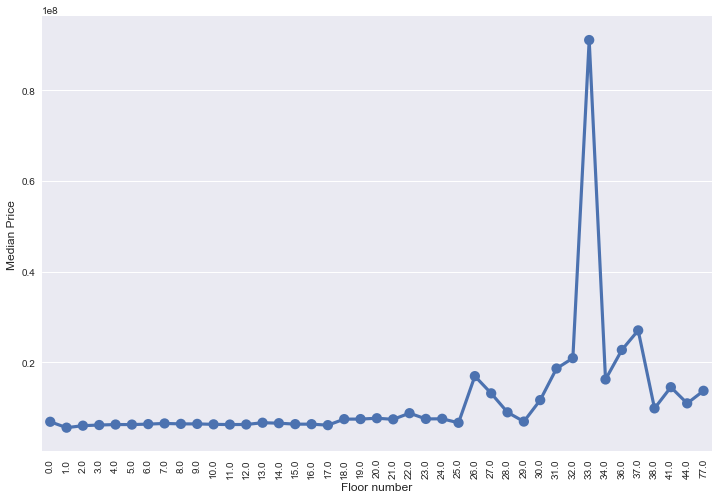

In [8]:
grouped_df = train_df.groupby('floor')['price_doc'].aggregate(np.median).reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df.floor.values, grouped_df.price_doc.values, alpha=0.8, color=color[0])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

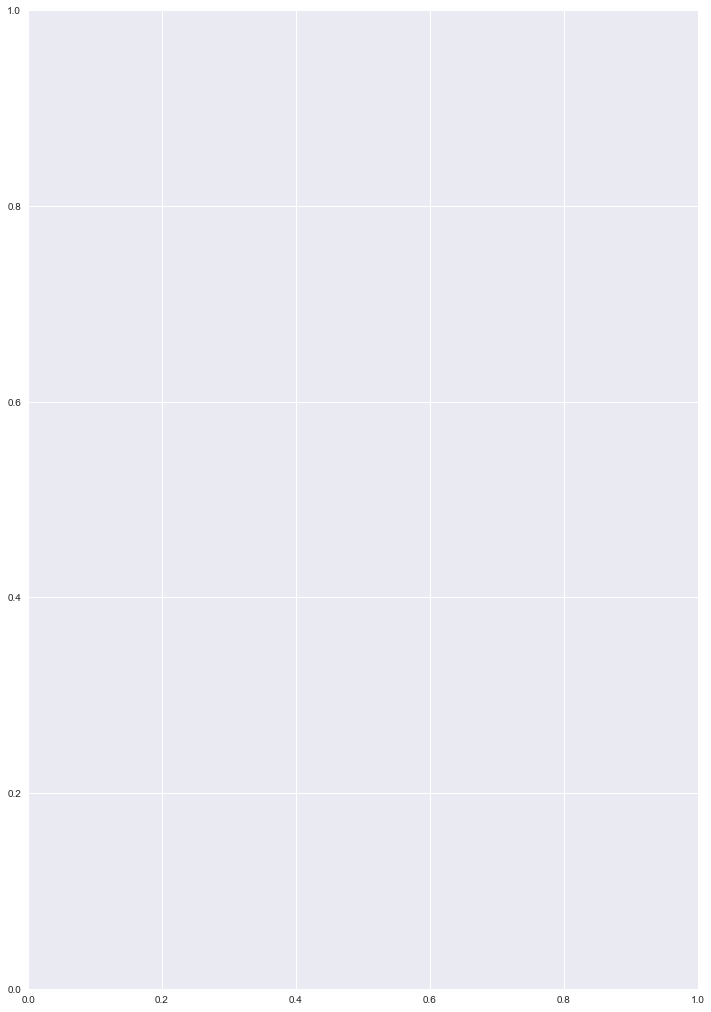

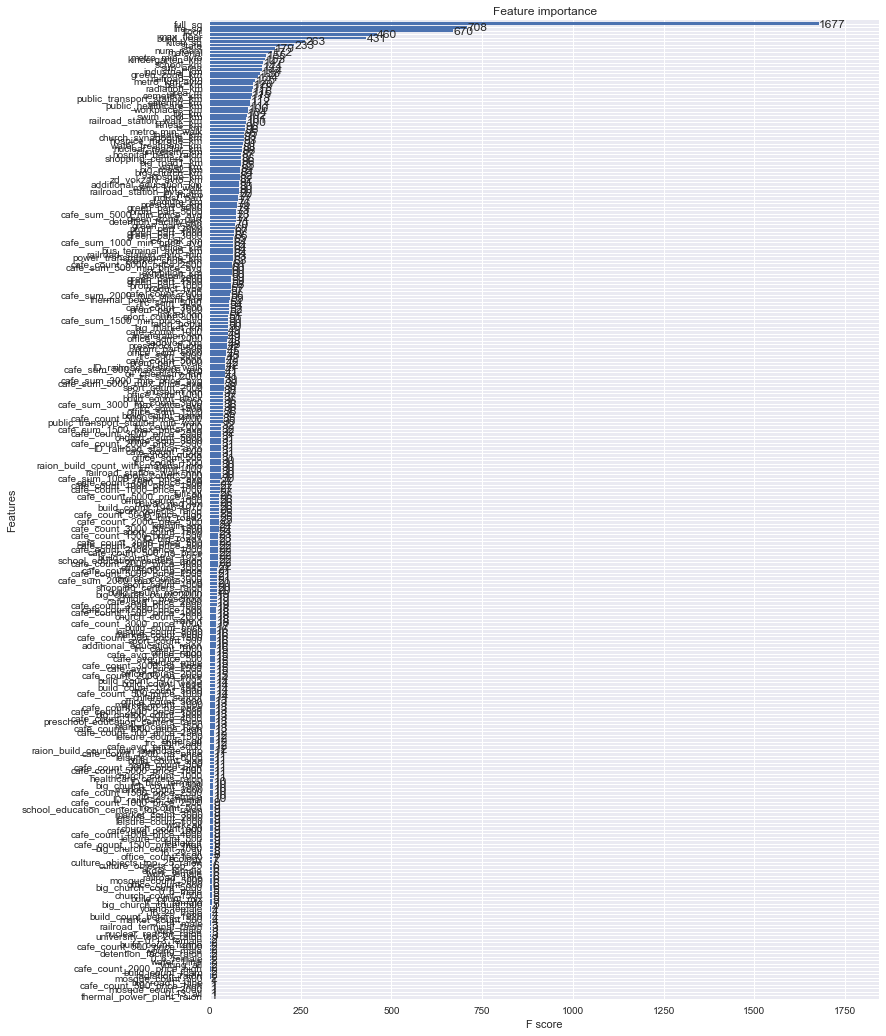

In [10]:
for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values)) 
        train_df[f] = lbl.transform(list(train_df[f].values))
        
train_y = train_df.price_doc.values
train_X = train_df.drop(["id", "timestamp", "price_doc"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

# plot the important features #
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()


In [6]:
# plot the important features #
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

ValueError: tree must be Booster, XGBModel or dict instance

In [38]:
def runXGB(train_x, train_y, test_x, test_y = None, feature_names = None, seed_val = 0, num_rounds = 1000):
    param = {}
    param['objective'] = 'reg:linear'
    param['eta'] = 0.1
    param['max_depth'] = 6
    #param['lambda'] = 2
    param['silent'] = 0
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    param['nthread'] = 4
    num_rounds = num_rounds
    
    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_x, label = train_y)
    
    if test_y is not None:
        xgtest = xgb.DMatrix(test_x, label = test_y)
        watchlist = [ (xgtrain, 'train'), (xgtest, 'test')]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds = 20)
    else:
        xgtest = xgb.DMatrix(test_x)
        model = xgb.train(plst, xgtrain, num_rounds)
    
    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

In [157]:
features_to_use = ['full_sq', 'life_rate', 'floor']
train_x = train_df[features_to_use].fillna(train_df[features_to_use].mean()).as_matrix()
test_x = test_df[features_to_use].fillna(train_df[features_to_use].mean()).as_matrix()

label_val = ['price_doc']
train_y = train_df[label_val].as_matrix()
preds, model = runXGB(train_x, train_y, test_x, num_rounds = 1000)
out_df = pd.DataFrame(preds)
out_df.columns = ['price_doc']
out_df['id'] = test_df.id.values
out_df.to_csv('test_output.csv', index = False)
out_df

,price_doc,listing_id
0,3402282.75,30474
1,7557041.00,30475
2,7054585.50,30476
3,8887360.00,30477
4,4620505.00,30478
5,5452743.00,30479
6,4969654.00,30480
7,5172696.50,30481
8,4459607.50,30482
9,5469278.50,30483


In [42]:
cv_scores = []
kf = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 2016)
for dev_index, val_index in kf.split(range(train_x.shape[0])):
    dev_x, val_x = train_x[dev_index, :], train_x[val_index, :]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB(dev_x, dev_y, val_x, val_y)
    cv_scores.append(log_loss(val_y, preds))
    print(cv_scores)
    break

Will train until test error hasn't decreased in 20 rounds.
[0]	train-rmse:7910120.000000	test-rmse:7731824.000000
[1]	train-rmse:7390950.000000	test-rmse:7214001.000000
[2]	train-rmse:6844406.500000	test-rmse:6680673.500000
[3]	train-rmse:6449081.500000	test-rmse:6286616.000000
[4]	train-rmse:6006384.000000	test-rmse:5868017.500000
[5]	train-rmse:5713483.000000	test-rmse:5579575.500000
[6]	train-rmse:5373509.500000	test-rmse:5260496.000000
[7]	train-rmse:5079086.500000	test-rmse:4987368.500000
[8]	train-rmse:4827943.500000	test-rmse:4754971.000000
[9]	train-rmse:4612160.500000	test-rmse:4566679.500000
[10]	train-rmse:4475367.500000	test-rmse:4436665.500000
[11]	train-rmse:4363657.000000	test-rmse:4330642.500000
[12]	train-rmse:4217512.000000	test-rmse:4207176.500000
[13]	train-rmse:4138448.250000	test-rmse:4134144.500000
[14]	train-rmse:4073845.500000	test-rmse:4074158.250000
[15]	train-rmse:4020258.000000	test-rmse:4025663.750000
[16]	train-rmse:3975701.750000	test-rmse:3985736.500000

ValueError: y_true and y_pred contain different number of classes 2507, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [   338570    354289    476902 ...,  60000000  61950000 111111112]

In [101]:
train_analyse = train_df.copy(deep=True)
test_analyse = test_df.copy(deep=True)

In [112]:
a = train_analyse.replace((train_analyse.full_sq > 300).index,train_analyse['full_sq'].mean())

KeyboardInterrupt: 

In [142]:
train_df.describe().astype(np.int64).T

,count,mean,std,min,25%,50%,75%,max
id,30471,15237,8796,1,7620,15238,22855,30473
full_sq,30471,54,38,0,38,49,63,5326
life_sq,24088,34,52,0,20,30,43,7478
floor,30304,7,5,0,3,6,11,77
max_floor,20899,12,6,0,9,12,17,117
material,20899,1,1,1,1,1,2,6
build_year,16866,3068,154387,0,1967,1979,2005,20052009
num_room,20899,1,0,0,1,2,2,19
kitch_sq,20899,6,28,0,1,6,9,2014
state,16912,2,0,1,1,2,3,33


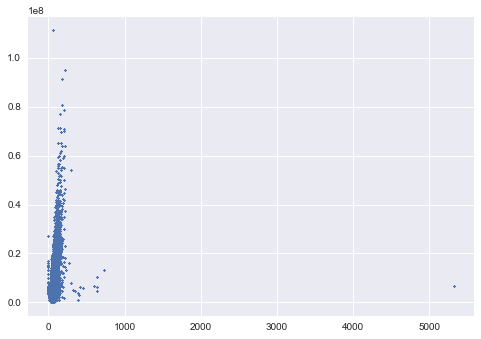

In [10]:
bad_index = train_df[train_df.life_sq > train_df.full_sq].index
train_df.loc[bad_index, "life_sq"] = np.NaN
equal_index = [601,1896,2791]
bad_index = train_df[train_df.life_sq < 5].index
train_df.loc[bad_index, "life_sq"] = np.NaN
plt.scatter(train_df['full_sq'][:],train_df['price_doc'][:],s=2,marker='x')
plt.show()

In [95]:
train_analyse

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452
5,6,2011-09-06,67,46.0,14.0,NaN,NaN,NaN,NaN,NaN,...,62,14,1,53,78,1,20,113,17,9100000
6,7,2011-09-08,25,14.0,10.0,NaN,NaN,NaN,NaN,NaN,...,81,16,3,38,80,1,27,127,8,5500000
7,8,2011-09-09,44,44.0,5.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,11,18,1,0,47,4,2000000
8,9,2011-09-10,42,27.0,5.0,NaN,NaN,NaN,NaN,NaN,...,19,8,1,18,34,1,3,85,11,5300000
9,10,2011-09-13,36,21.0,9.0,NaN,NaN,NaN,NaN,NaN,...,19,13,0,10,20,1,3,67,1,2000000


In [149]:
bad_index = train_df[train_df.life_sq < 10].index
train_df.loc[bad_index, "full_sq"] = np.NaN

In [150]:
bad_index

Int64Index([  104,   702,   858,  1085,  1107,  1596,  2778,  2906,  3426,
             3800,
            ...
            30341, 30353, 30364, 30375, 30391, 30419, 30435, 30441, 30453,
            30458],
           dtype='int64', length=458)

In [151]:
train_df

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43.0,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34.0,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43.0,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89.0,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77.0,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452
5,6,2011-09-06,67.0,46.0,14.0,NaN,NaN,NaN,NaN,NaN,...,62,14,1,53,78,1,20,113,17,9100000
6,7,2011-09-08,25.0,14.0,10.0,NaN,NaN,NaN,NaN,NaN,...,81,16,3,38,80,1,27,127,8,5500000
7,8,2011-09-09,44.0,44.0,5.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,11,18,1,0,47,4,2000000
8,9,2011-09-10,42.0,27.0,5.0,NaN,NaN,NaN,NaN,NaN,...,19,8,1,18,34,1,3,85,11,5300000
9,10,2011-09-13,36.0,21.0,9.0,NaN,NaN,NaN,NaN,NaN,...,19,13,0,10,20,1,3,67,1,2000000


In [156]:
train_df['life_rate'] = (train_df['life_sq']) / train_df['full_sq']
train_df
test_df['life_rate'] = (test_df['life_sq']) / test_df['full_sq']
test_df

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,life_rate
0,30474,2015-07-01,39.00,20.70,2,9,1,1998.0,1,8.9,...,0,0,0,1,10,1,0,14,1,0.530769
1,30475,2015-07-01,79.20,NaN,8,17,1,0.0,3,1.0,...,1,1,0,2,11,0,1,12,1,NaN
2,30476,2015-07-01,40.50,25.10,3,5,2,1960.0,2,4.8,...,11,4,0,10,21,0,10,71,11,0.619753
3,30477,2015-07-01,62.80,36.00,17,17,1,2016.0,2,62.8,...,1,2,0,0,10,0,0,2,0,0.573248
4,30478,2015-07-01,40.00,40.00,17,17,1,0.0,1,1.0,...,1,1,0,2,12,0,1,11,1,1.000000
5,30479,2015-07-01,48.43,NaN,21,1,1,2015.0,1,1.0,...,99,57,12,23,42,1,13,123,7,NaN
6,30480,2015-07-01,38.80,NaN,15,17,1,NaN,1,1.0,...,7,2,0,5,14,0,3,17,2,NaN
7,30481,2015-07-01,43.10,NaN,5,0,1,NaN,1,0.0,...,2,2,0,3,12,0,0,6,3,NaN
8,30482,2015-07-01,45.40,28.50,9,12,5,1972.0,2,6.0,...,1,0,0,1,7,0,0,7,0,0.627753
9,30483,2015-07-01,43.30,43.30,7,22,1,0.0,1,1.0,...,2,1,0,2,9,0,0,7,0,1.000000


In [160]:
bad_index = train[train.life_sq > train.full_sq].index
train.ix[bad_index, "life_sq"] = np.NaN
equal_index = [601,1896,2791]
test.ix[equal_index, "life_sq"] = test.ix[equal_index, "full_sq"]
bad_index = test[test.life_sq > test.full_sq].index
test.ix[bad_index, "life_sq"] = np.NaN
bad_index = train[train.life_sq < 5].index
train.ix[bad_index, "life_sq"] = np.NaN
bad_index = test[test.life_sq < 5].index
test.ix[bad_index, "life_sq"] = np.NaN
bad_index = train[train.full_sq < 5].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[test.full_sq < 5].index
test.ix[bad_index, "full_sq"] = np.NaN
kitch_is_build_year = [13117]
train.ix[kitch_is_build_year, "build_year"] = train.ix[kitch_is_build_year, "kitch_sq"]
bad_index = train[train.kitch_sq >= train.life_sq].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[test.kitch_sq >= test.life_sq].index
test.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = train[(train.kitch_sq == 0).values + (train.kitch_sq == 1).values].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[(test.kitch_sq == 0).values + (test.kitch_sq == 1).values].index
test.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = train[(train.full_sq > 210) & (train.life_sq / train.full_sq < 0.3)].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[(test.full_sq > 150) & (test.life_sq / test.full_sq < 0.3)].index
test.ix[bad_index, "full_sq"] = np.NaN
bad_index = train[train.life_sq > 300].index
train.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
bad_index = test[test.life_sq > 200].index
test.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
train.product_type.value_counts(normalize= True)
test.product_type.value_counts(normalize= True)
bad_index = train[train.build_year < 1500].index
train.ix[bad_index, "build_year"] = np.NaN
bad_index = test[test.build_year < 1500].index
test.ix[bad_index, "build_year"] = np.NaN
bad_index = train[train.num_room == 0].index 
train.ix[bad_index, "num_room"] = np.NaN
bad_index = test[test.num_room == 0].index 
test.ix[bad_index, "num_room"] = np.NaN
bad_index = [10076, 11621, 17764, 19390, 24007, 26713, 29172]
train.ix[bad_index, "num_room"] = np.NaN
bad_index = [3174, 7313]
test.ix[bad_index, "num_room"] = np.NaN
bad_index = train[(train.floor == 0).values * (train.max_floor == 0).values].index
train.ix[bad_index, ["max_floor", "floor"]] = np.NaN
bad_index = train[train.floor == 0].index
train.ix[bad_index, "floor"] = np.NaN
bad_index = train[train.max_floor == 0].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.max_floor == 0].index
test.ix[bad_index, "max_floor"] = np.NaN
bad_index = train[train.floor > train.max_floor].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.floor > test.max_floor].index
test.ix[bad_index, "max_floor"] = np.NaN
train.floor.describe(percentiles= [0.9999])
bad_index = [23584]
train.ix[bad_index, "floor"] = np.NaN
train.material.value_counts()
test.material.value_counts()
train.state.value_counts()
bad_index = train[train.state == 33].index
train.ix[bad_index, "state"] = np.NaN
test.state.value_counts()

c:\python27\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  
c:\python27\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


2.0    2662
1.0    2266
3.0    1913
4.0     127
Name: state, dtype: int64

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime

#load files
train = pd.read_csv('train.csv', parse_dates=['timestamp'])
test = pd.read_csv('test.csv', parse_dates=['timestamp'])
macro = pd.read_csv('macro.csv', parse_dates=['timestamp'])
id_test = test.id
test.product_type.fillna('Investment',inplace=True)


#multiplier = 0.969

#clean data
bad_index = train[train.life_sq > train.full_sq].index
train.ix[bad_index, "life_sq"] = np.NaN
equal_index = [601,1896,2791]
test.ix[equal_index, "life_sq"] = test.ix[equal_index, "full_sq"]
bad_index = test[test.life_sq > test.full_sq].index
test.ix[bad_index, "life_sq"] = np.NaN
bad_index = train[train.life_sq < 5].index
train.ix[bad_index, "life_sq"] = np.NaN
bad_index = test[test.life_sq < 5].index
test.ix[bad_index, "life_sq"] = np.NaN
bad_index = train[train.full_sq < 5].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[test.full_sq < 5].index
test.ix[bad_index, "full_sq"] = np.NaN
kitch_is_build_year = [13117]
train.ix[kitch_is_build_year, "build_year"] = train.ix[kitch_is_build_year, "kitch_sq"]
bad_index = train[train.kitch_sq >= train.life_sq].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[test.kitch_sq >= test.life_sq].index
test.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = train[(train.kitch_sq == 0).values + (train.kitch_sq == 1).values].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[(test.kitch_sq == 0).values + (test.kitch_sq == 1).values].index
test.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = train[(train.full_sq > 210) & (train.life_sq / train.full_sq < 0.3)].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[(test.full_sq > 150) & (test.life_sq / test.full_sq < 0.3)].index
test.ix[bad_index, "full_sq"] = np.NaN
bad_index = train[train.life_sq > 300].index
train.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
bad_index = test[test.life_sq > 200].index
test.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
train.product_type.value_counts(normalize= True)
test.product_type.value_counts(normalize= True)
bad_index = train[train.build_year < 1500].index
train.ix[bad_index, "build_year"] = np.NaN
bad_index = test[test.build_year < 1500].index
test.ix[bad_index, "build_year"] = np.NaN
bad_index = train[train.num_room == 0].index 
train.ix[bad_index, "num_room"] = np.NaN
bad_index = test[test.num_room == 0].index 
test.ix[bad_index, "num_room"] = np.NaN
bad_index = [10076, 11621, 17764, 19390, 24007, 26713, 29172]
train.ix[bad_index, "num_room"] = np.NaN
bad_index = [3174, 7313]
test.ix[bad_index, "num_room"] = np.NaN
bad_index = train[(train.floor == 0).values * (train.max_floor == 0).values].index
train.ix[bad_index, ["max_floor", "floor"]] = np.NaN
bad_index = train[train.floor == 0].index
train.ix[bad_index, "floor"] = np.NaN
bad_index = train[train.max_floor == 0].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.max_floor == 0].index
test.ix[bad_index, "max_floor"] = np.NaN
bad_index = train[train.floor > train.max_floor].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.floor > test.max_floor].index
test.ix[bad_index, "max_floor"] = np.NaN
train.floor.describe(percentiles= [0.9999])
bad_index = [23584]
train.ix[bad_index, "floor"] = np.NaN
train.material.value_counts()
test.material.value_counts()
train.state.value_counts()
bad_index = train[train.state == 33].index
train.ix[bad_index, "state"] = np.NaN
test.state.value_counts()

# brings error down a lot by removing extreme price per sqm
train.loc[train.full_sq == 0, 'full_sq'] = 50
train = train[train.price_doc/train.full_sq <= 600000]
train = train[train.price_doc/train.full_sq >= 10000]

# Add month-year
month_year = (train.timestamp.dt.month + train.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
train['month_year_cnt'] = month_year.map(month_year_cnt_map)

month_year = (test.timestamp.dt.month + test.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
test['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (train.timestamp.dt.weekofyear + train.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
train['week_year_cnt'] = week_year.map(week_year_cnt_map)

week_year = (test.timestamp.dt.weekofyear + test.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
test['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
train['month'] = train.timestamp.dt.month
train['dow'] = train.timestamp.dt.dayofweek

test['month'] = test.timestamp.dt.month
test['dow'] = test.timestamp.dt.dayofweek

# Other feature engineering
train['rel_floor'] = train['floor'] / train['max_floor'].astype(float)
train['rel_kitch_sq'] = train['kitch_sq'] / train['full_sq'].astype(float)

test['rel_floor'] = test['floor'] / test['max_floor'].astype(float)
test['rel_kitch_sq'] = test['kitch_sq'] / test['full_sq'].astype(float)

train.apartment_name=train.sub_area + train['metro_km_avto'].astype(str)
test.apartment_name=test.sub_area + train['metro_km_avto'].astype(str)

train['room_size'] = train['life_sq'] / train['num_room'].astype(float)
test['room_size'] = test['life_sq'] / test['num_room'].astype(float)


#x_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
#x_test = test.drop(["id", "timestamp"], axis=1)

my_macro=macro[[]]
my_train=train.join(my_macro,on='timestamp',how='left')
my_test=test.join(my_macro,on='timestamp',how='left')
my_train_1=my_train[my_train['product_type']=='Investment']


my_test_1=my_test[my_test['product_type']=='Investment']




id_test=my_test_1.id
y_train=my_train_1.price_doc
train_df = my_train_1.drop(["id", "timestamp", "price_doc"], axis=1)
test_df = my_test_1.drop(["id", "timestamp"], axis=1)


num_train = len(train_df)
x_all = pd.concat([train_df, test_df])

for c in x_all.columns:
    if x_all[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_all[c].values))
        x_all[c] = lbl.transform(list(x_all[c].values))
        #x_train.drop(c,axis=1,inplace=True)

x_train = x_all[:num_train]
x_test = x_all[num_train:]

x_train.fillna(x_train.mean(),inplace=True)

x_test.fillna(x_test.mean(),inplace=True)

xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)


num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

#fig, ax = plt.subplots(1, 1, figsize=(8, 13))
#xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

y_predict = model.predict(dtest)
y_predict = np.round(y_predict)
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})

output.to_csv('xgbwithcleaningo.csv', index=False)

c:\python27\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
c:\python27\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
c:\python27\lib\site-packages\pandas\core\generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
Will train until cv error hasn't decreased in 20 rounds.
[0]	cv-test-rmse:8633317.66667	cv-train-rmse:8624014.0
[50]	cv-test-rmse:3219660.33333	cv-train-r